# Thử nghiệm nhận diện mặt người nổi tiếng Việt Nam

## Phần sử dụng trực tiếp FaceNet + 2 lớp Dense
* Thất bại do:
    * Tập dữ liệu tự làm quá nhỏ, không đủ tốt
    * Thử nghiệm với nhiều hàm optimize (Adam, Adadelta, Adagrad, RMSprop, SGD, ...) + nhiều learning rate khác nhau vẫn không lên nổi
    * Cao nhất được accuracy 20% nhưng chưa kịp lưu thì bị die kernel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/CodeFC/[self_built]-vn_celeb_face_data.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/CodeFC/")
!pip install keras_facenet
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install mtcnn

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-_um3jaws
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-_um3jaws
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=21d24f03b0e6a17cf1e3f063e2cb5379a9e8bb66816925884d59081f76d23e76
  Stored in directory: /tmp/pip-ephem-wheel-cache-lvriuzof/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
%cd "/content/drive/MyDrive/PPNCKH/"

/content/drive/MyDrive/PPNCKH


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

In [ ]:
# Check for GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
TEST_PATH = './[self_built]-vn_celeb_face_data/data/test'
TEST_ALIGNED_PATH = './[self_built]-vn_celeb_face_data/data/test_aligned'
TRAIN_PATH = './[self_built]-vn_celeb_face_data/data/train'
TRAIN_ALIGNED_PATH = './[self_built]-vn_celeb_face_data/data/train_aligned'

BATCH_SIZE = 16
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
random_seed2 = 5

train_set = image_dataset_from_directory(TRAIN_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='training', seed=random_seed2)
val_set = image_dataset_from_directory(TRAIN_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='validation', seed=random_seed2)
test_set = image_dataset_from_directory(TEST_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 2957 files belonging to 144 classes.
Using 2366 files for training.
Found 2957 files belonging to 144 classes.
Using 591 files for validation.
Found 643 files belonging to 144 classes.


In [ ]:
random_seed = 10

train_aligned_set = image_dataset_from_directory(TRAIN_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='training', seed=random_seed)
val_aligned_set = image_dataset_from_directory(TRAIN_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='validation', seed=random_seed)
test_aligned_set = image_dataset_from_directory(TEST_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2957 files belonging to 144 classes.
Using 2366 files for training.
Found 2957 files belonging to 144 classes.
Using 591 files for validation.
Found 643 files belonging to 144 classes.


In [ ]:
CLASSES = train_set.class_names

NAMES = [line.strip() for line in open('./[self_built]-vn_celeb_face_data/original_labels.txt', 'r', encoding='UTF-8')]

print(len(NAMES))

144


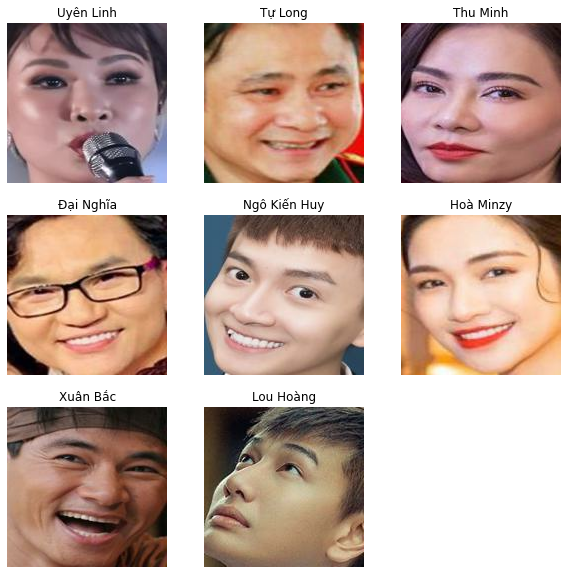

In [ ]:
# Show the first 8 images (1 batch) and labels in the training set
plt.figure(figsize = (10, 10))
for images, labels in train_set.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        #print(images[i].numpy().astype('uint8'))
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(NAMES[int(CLASSES[labels[i]])])
        plt.axis('off')

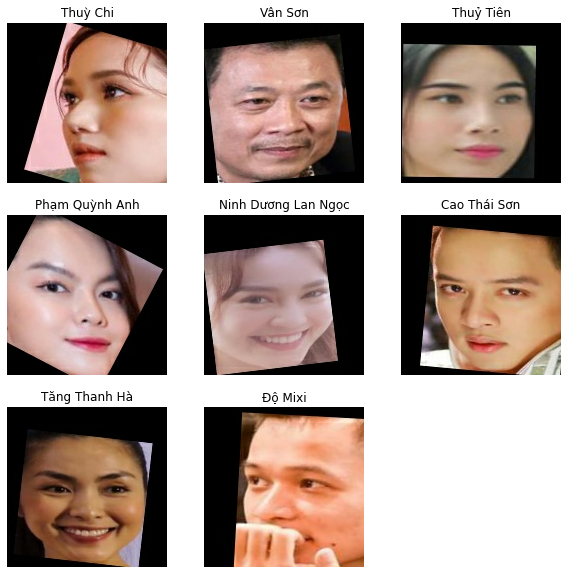

In [ ]:
# Try again with aligned train images
plt.figure(figsize = (10, 10))
for images, labels in train_aligned_set.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        #print(images[i].numpy().astype('uint8'))
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(NAMES[int(CLASSES[labels[i]])])
        plt.axis('off')

In [ ]:
# To improve image loading performance
AUTOTUNE = tf.data.experimental.AUTOTUNE # for tf 2.3-; for tf 2.4+ remove 'experimental'

train_aligned_set = train_aligned_set.prefetch(buffer_size = AUTOTUNE)
val_set = val_set.prefetch(buffer_size = AUTOTUNE)
test_set = test_set.prefetch(buffer_size = AUTOTUNE)

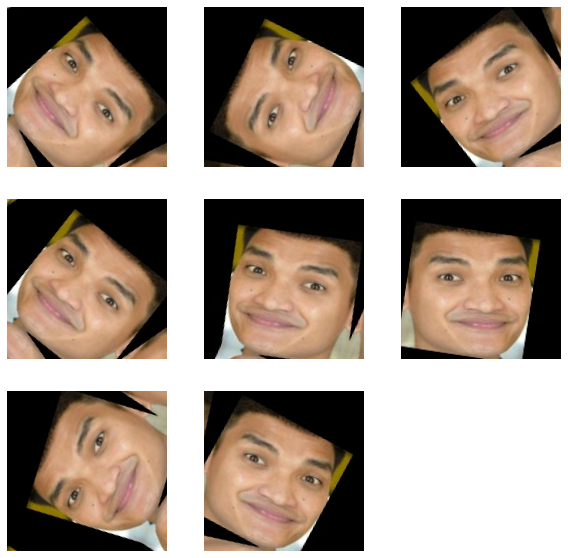

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'), tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
# more augmentation recommended if resource is abundant

# Test with an image to see the augmentations
for images, _ in train_aligned_set.take(1):
    plt.figure(figsize = (10, 10))
    image = images[0]
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
MODEL_PATH = './models/'

In [ ]:
from keras.models import load_model
# load the model
face_net_model = load_model(MODEL_PATH+'facenet_keras.h5')
face_net_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [ ]:
# Add 2 dense layers
dense_layer = tf.keras.layers.Dense(512) # if resource allows, try bigger number of neurals
output_layer = tf.keras.layers.Dense(len(CLASSES), activation = 'softmax') # 144 classes, use softmax for multi class

# Compile the model
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = face_net_model(inputs)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
dense_1 (Dense)              (None, 144)               18576     
Total params: 22,826,720
Trainable params: 22,797,888
Non-trainable params: 28,832
_________________________________________________________________


In [ ]:
WEIGHT_PATH = MODEL_PATH + 'classifier_face_net_model.h5'
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.get_layer('inception_resnet_v1').trainable = False
if os.path.exists(WEIGHT_PATH):
    model.load_weights(WEIGHT_PATH)
# model.load_weights(MODEL_PATH + 'pretrained.h5')

In [ ]:
with tf.device('/device:GPU:0'):
# initial loss & accuracy
    loss0, accuracy0 = model.evaluate(val_aligned_set)

37/37 [==============================] - 8s 63ms/step - loss: 7.4138 - accuracy: 0.0111


In [ ]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_aligned_set, epochs=20, validation_data=val_aligned_set) # try more epochs if time allows

Epoch 1/20
148/148 [==============================] - 28s 129ms/step - loss: 3.5975 - accuracy: 0.2532 - val_loss: 3.7780 - val_accuracy: 0.1624
Epoch 2/20
148/148 [==============================] - 18s 120ms/step - loss: 1.5423 - accuracy: 0.7549 - val_loss: 2.5783 - val_accuracy: 0.5262
Epoch 3/20
148/148 [==============================] - 18s 118ms/step - loss: 0.5424 - accuracy: 0.9493 - val_loss: 2.0957 - val_accuracy: 0.6548
Epoch 4/20
148/148 [==============================] - 18s 118ms/step - loss: 0.1577 - accuracy: 0.9911 - val_loss: 1.2174 - val_accuracy: 0.7936
Epoch 5/20
148/148 [==============================] - 18s 118ms/step - loss: 0.0712 - accuracy: 0.9924 - val_loss: 0.8588 - val_accuracy: 0.8443
Epoch 6/20
148/148 [==============================] - 18s 119ms/step - loss: 0.0403 - accuracy: 0.9945 - val_loss: 0.7228 - val_accuracy: 0.8613
Epoch 7/20
148/148 [==============================] - 18s 119ms/step - loss: 0.0330 - accuracy: 0.9954 - val_loss: 0.6922 - val_ac

In [ ]:
model.save_weights(WEIGHT_PATH)

In [ ]:
with tf.device('/device:GPU:0'):
    model.evaluate(test_aligned_set)

41/41 [==============================] - 3s 60ms/step - loss: 0.7190 - accuracy: 0.8398


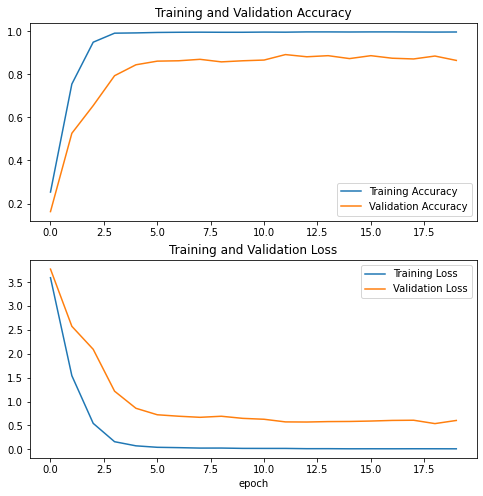

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

## Phần thử nghiệm với VGG Face 2

In [ ]:
pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: six, keras, h5py, numpy, pillow, pyyaml, scipy
Required-by: 


In [ ]:
# check version of keras_vggface
import keras_vggface
# print version
print(keras_vggface.__version__)

0.6


In [ ]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import tensorflow as tf
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
from keras.callbacks import EarlyStopping

IMG_SIZE_VGG = (224, 224)
random_seed = 10

train_aligned_set = image_dataset_from_directory(TRAIN_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE_VGG, validation_split=0.2, subset='training', seed=random_seed)
val_aligned_set = image_dataset_from_directory(TRAIN_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE_VGG, validation_split=0.2, subset='validation', seed=random_seed)
test_aligned_set = image_dataset_from_directory(TEST_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE_VGG)

nb_class = len(train_aligned_set.class_names)

vgg_model = VGGFace(model='senet50', input_shape=(224, 224, 3))
vgg_model.summary()
vgg_model.trainable=False
last_layer = vgg_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(nb_class, activation='softmax', name='classifier')(x)
custom_vgg_model = Model(vgg_model.input, out)

Found 2957 files belonging to 144 classes.
Using 2366 files for training.
Found 2957 files belonging to 144 classes.
Using 591 files for validation.
Found 643 files belonging to 144 classes.
Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
___________________________________________________________________________________________

In [ ]:
WEIGHT_PATH = MODEL_PATH + 'classifier_vgg_model.h5'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
custom_vgg_model.compile(optimizer=optimizer,
          loss=loss_fn,
          metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
# initial loss & accuracy
    loss0, accuracy0 = custom_vgg_model.evaluate(val_aligned_set)

37/37 [==============================] - 6s 93ms/step - loss: 16.9608 - accuracy: 0.0050


In [ ]:
with tf.device('/device:GPU:0'):
    if os.path.exists(WEIGHT_PATH):
        custom_vgg_model.load_weights(WEIGHT_PATH)
    custom_vgg_model.fit(train_aligned_set, epochs=20, validation_data=val_aligned_set)

Epoch 1/20
148/148 [==============================] - 19s 106ms/step - loss: 4.9544 - accuracy: 0.4856 - val_loss: 1.5895 - val_accuracy: 0.7530
Epoch 2/20
148/148 [==============================] - 15s 101ms/step - loss: 0.4665 - accuracy: 0.9049 - val_loss: 1.2333 - val_accuracy: 0.8206
Epoch 3/20
148/148 [==============================] - 15s 101ms/step - loss: 0.2285 - accuracy: 0.9446 - val_loss: 1.2463 - val_accuracy: 0.8257
Epoch 4/20
148/148 [==============================] - 15s 101ms/step - loss: 0.1969 - accuracy: 0.9577 - val_loss: 1.3649 - val_accuracy: 0.8342
Epoch 5/20
148/148 [==============================] - 15s 101ms/step - loss: 0.1411 - accuracy: 0.9670 - val_loss: 1.4664 - val_accuracy: 0.8156
Epoch 6/20
148/148 [==============================] - 15s 101ms/step - loss: 0.1347 - accuracy: 0.9755 - val_loss: 1.1837 - val_accuracy: 0.8528
Epoch 7/20
148/148 [==============================] - 15s 101ms/step - loss: 0.2193 - accuracy: 0.9556 - val_loss: 1.6220 - val_ac

In [ ]:
custom_vgg_model.save_weights(MODEL_PATH + 'vgg-face.h5')

In [ ]:
with tf.device('/device:GPU:0'):
    custom_vgg_model.evaluate(test_aligned_set)

41/41 [==============================] - 4s 89ms/step - loss: 2.9766 - accuracy: 0.7900


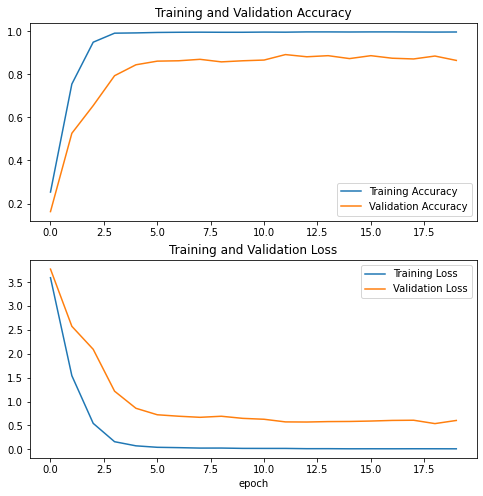

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

## Phần thử nghiệm với embedding vectors
* 512 chiều, không khả thi để train (do máy hơi cùi), 1 epoch chạy rất lâu

In [ ]:

emb_gen = FaceNet()

NameError: ignored

In [ ]:
def prepare_emb(dataset):
    return dataset.map(lambda img, lbl: (emb_gen.model(img), lbl))

In [ ]:
emb_train_set = prepare_emb(train_set)
emb_test_set = prepare_emb(test_set)
emb_val_set = prepare_emb(val_set)

In [ ]:
emb_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(512, input_dim=512, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax'),
    ]
)
emb_model.summary()

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.01)

emb_model.compile(optimizer=optim, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
emb_hist = emb_model.fit(emb_train_set, epochs=50, validation_data=emb_val_set)